<a href="https://colab.research.google.com/github/petergchang/proximal_jax/blob/main/1_Introduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Jaxified Notes on Proximal Algorithms: 1. Introduction

Notes from https://web.stanford.edu/~boyd/papers/prox_algs.html.

Adapted to JAX by [@petergchang](https://github.com/petergchang).

In [1]:
from itertools import product

import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax.random as jr
from jax import vmap
from jax.numpy.linalg import norm
from jax.scipy.optimize import minimize

# 1. Univariate Example

First, we define the *proximal operator*.

In [2]:
# argmin of a function
def fn_argmin(fn, initial_guess=0.0, fp_digits=2):
    opt_result = minimize(fn, jnp.atleast_1d(initial_guess), method='BFGS')
    return round(opt_result.x, fp_digits)

In [77]:
# Define general proximal operator
def proximal_operator(fn, v, lamb=1):
    new_fn = lambda x: fn(x) + 1/(2*lamb) * norm(x-v)**2
    return fn_argmin(new_fn, initial_guess=jnp.zeros(jnp.atleast_1d(v).shape))

As a simple example, we consider the convex function $f(x) = x^2$ with domain $\mathbb{R}$.

In [78]:
def convex_fn_1d(x):
    """ Simple convex function R->R
    """
    return jnp.reshape(x**2, ())

# Vectorized version
vec_convex_fn_1d = vmap(convex_fn_1d)

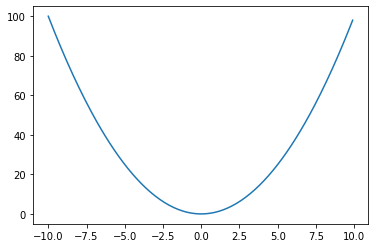

In [79]:
input_grid = jnp.arange(-10, 10, 0.1)
plt.plot(input_grid, vec_convex_fn_1d(input_grid));

We observe how the proximal operator moves uniformly-sampled points towards the minimum of the function (i.e. $x=0$).

In [80]:
random_points = jr.uniform(jr.PRNGKey(0), shape=(10,), minval=-10, maxval=10)

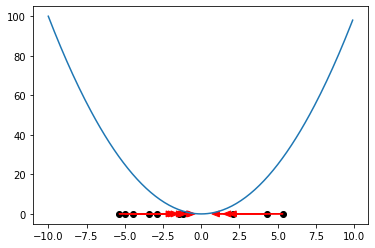

In [81]:
fig, ax = plt.subplots()
ax.plot(input_grid, vec_convex_fn_1d(input_grid))
for point in random_points:
    post_proximal_point = proximal_operator(convex_fn_1d, point)[0]
    # Plot input
    ax.scatter(point, 0, c='black')
    # Indicate proximal operator
    ax.arrow(point, 0, post_proximal_point-point, 0, head_length=0.5,
             head_width=3, length_includes_head=True, color='red');

Note that the proximal operator moves every number towards the minimum of the function.

We can analytically derive the solution:
\begin{align}
\textbf{prox}_{\lambda f}(v) &= \text{argmin}_{x}\left( x^2 + \frac{(x-v)^2}{2\lambda} \right) \\
&= \text{root}_{x} \left( 2x + \frac{x - v}{\lambda} \right) \\
&= \frac{v}{2 \lambda + 1}
\end{align}

# 2. Bivariate Example

Next, we consider the bivariate function $f: \mathbb{R}^2 \rightarrow \mathbb{R}$:
\begin{align}
    f(x, y) &= \log(1 - x^2 + y)
\end{align}

In [9]:
# Example of convex function
def convex_fn_2d(x):
    """ Simple convex function R2->R
    """
    return jnp.log(1 - x[0]**2 + x[1])

Note that the domain of the function is:
\begin{align}
    \text{dom}(f) &= \{(x, y) \in \mathbb{R}^{2}: 1 - x^2 + y > 0\} \\
    &= \{(x, y) \in \mathbb{R}^{2}:y > x^2 - 1\}
\end{align}

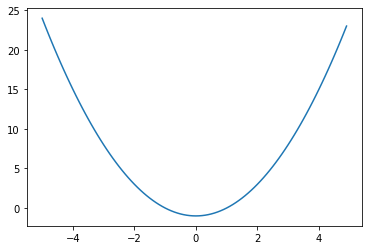

In [10]:
x = jnp.arange(-5, 5, 0.1)
y = jnp.arange(-5, 5, 0.1)
domain = lambda x: x**2 - 1

# Plot the domain boundary
plt.plot(x, domain(x));

Let us examine at the contour plot of the function.

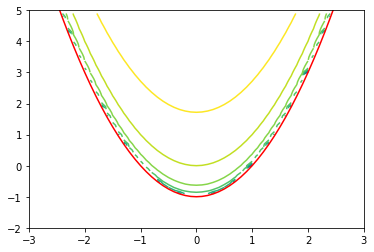

In [42]:
# Define meshgrid
xx, yy = jnp.meshgrid(x, y)
z = convex_fn_2d([xx, yy])

# Plot contour of function
fig, ax = plt.subplots()
ax.contour(xx, yy, z, levels=jnp.arange(-10, 2))

# Plot domain of function
ax.plot(x, domain(x), c='red')
ax.set_ylim(-2, 5)
ax.set_xlim(-3, 3);

Next, let us see what happens to points in the domain when they pass through the proximal operator.

In [62]:
in_domain_points = jnp.array([[0, 2], [1, 3], [-1, 2]])
in_domain_post_proximal_points = jnp.array([proximal_operator(convex_fn_2d, pt) for pt in in_domain_points])

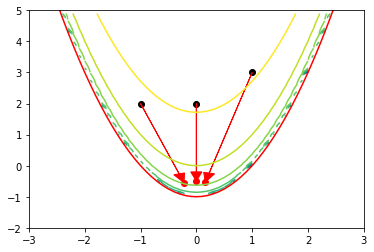

In [65]:
# Plot contour of function
fig, ax = plt.subplots()
ax.contour(xx, yy, z, levels=jnp.arange(-10, 2))
ax.set_ylim(-2, 5)

# Plot domain of function
ax.plot(x, domain(x), c='red')

for _, pt in enumerate(zip(in_domain_points, in_domain_post_proximal_points)):
    # Plot initial point
    ax.scatter(*pt[0], c='black')

    # Plot post-proximal point
    ax.scatter(*pt[1], c='r')
    ax.arrow(*pt[0], *(pt[1]-pt[0]), head_length=0.3,
                head_width=0.2, length_includes_head=True, color='red');

ax.set_ylim(-2, 5)
ax.set_xlim(-3, 3);

Finally, we observe what happens to points outside the domain.

In [66]:
out_domain_points = jnp.array([[0, -2], [2, -1], [-2, 0]])
out_domain_post_proximal_points = jnp.array([proximal_operator(convex_fn_2d, pt) for pt in in_domain_points])

In [75]:
points = jnp.concatenate([in_domain_points, out_domain_points])
post_proximal_points = jnp.concatenate([in_domain_post_proximal_points, out_domain_post_proximal_points])

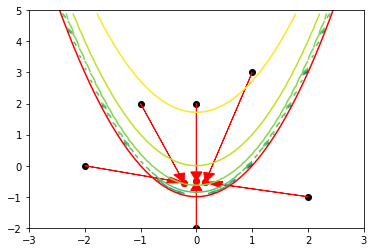

In [76]:
# Plot contour of function
fig, ax = plt.subplots()
ax.contour(xx, yy, z, levels=jnp.arange(-10, 2))
ax.set_ylim(-2, 5)

# Plot domain of function
ax.plot(x, domain(x), c='red')

for _, pt in enumerate(zip(points, post_proximal_points)):
    # Plot initial point
    ax.scatter(*pt[0], c='black')

    # Plot post-proximal point
    ax.scatter(*pt[1], c='r')
    ax.arrow(*pt[0], *(pt[1]-pt[0]), head_length=0.3,
                head_width=0.2, length_includes_head=True, color='red');

ax.set_ylim(-2, 5)
ax.set_xlim(-3, 3);